# 🧠 Neuromatch — Coding Notebook

## 👥 Group 2 Members:

- **Mohammad Mahdi Razmjoo**
- **Adel Movahedian**
- **Shadi Mohammadi**
- **Mohammad Hassan Jalili**

---
---
---

# Data Visualization

In [1]:
# Cell 1: Imports and Styling

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# set up nice plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Cell 2: Define Paths & Load Metadata CSVs

BASE_DIR    = "/kaggle/input/chest-xrays-indiana-university"
PROJ_CSV    = os.path.join(BASE_DIR, "indiana_projections.csv")
REPORT_CSV  = os.path.join(BASE_DIR, "indiana_reports.csv")
IMAGE_DIR   = os.path.join(BASE_DIR, "images", "images_normalized")

# Load into DataFrames
projections = pd.read_csv(PROJ_CSV)
reports     = pd.read_csv(REPORT_CSV)

# Quick sanity check
print("Projections columns:", projections.columns.tolist())
print("Reports     columns:", reports.columns.tolist())

Projections columns: ['uid', 'filename', 'projection']
Reports     columns: ['uid', 'MeSH', 'Problems', 'image', 'indication', 'comparison', 'findings', 'impression']


In [3]:
# Cell 3: Merge Metadata & Build Filepaths

# Join on the shared 'uid' column
meta = projections.merge(reports, on="uid", how="left")

# Construct full image paths
meta['filepath'] = meta['filename'].apply(lambda fn: os.path.join(IMAGE_DIR, fn))

# Filter out any entries whose image file is missing
meta = meta[meta['filepath'].map(os.path.exists)].reset_index(drop=True)

print(f"Total images available: {len(meta)}")
meta.head()

Total images available: 7466


,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression,filepath
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,/kaggle/input/chest-xrays-indiana-university/i...
1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.,/kaggle/input/chest-xrays-indiana-university/i...
2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,/kaggle/input/chest-xrays-indiana-university/i...
3,2,2_IM-0652-2001.dcm.png,Lateral,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.,/kaggle/input/chest-xrays-indiana-university/i...
4,3,3_IM-1384-1001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p...",/kaggle/input/chest-xrays-indiana-university/i...


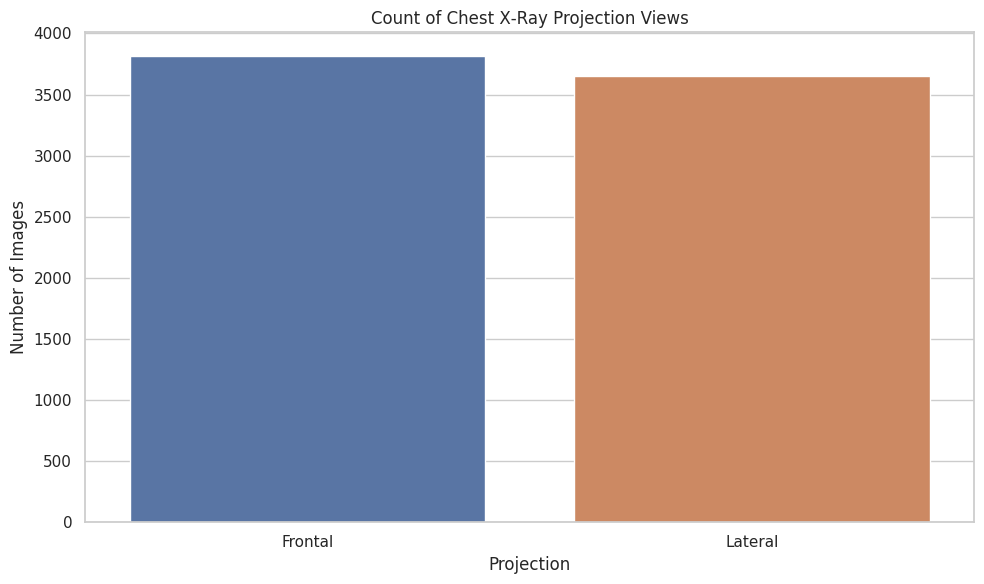

In [4]:
# Cell 4: Distribution of Projection Views

plt.figure()
sns.countplot(data=meta, x="projection",
              order=meta['projection'].value_counts().index)
plt.title("Count of Chest X‑Ray Projection Views")
plt.xlabel("Projection")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

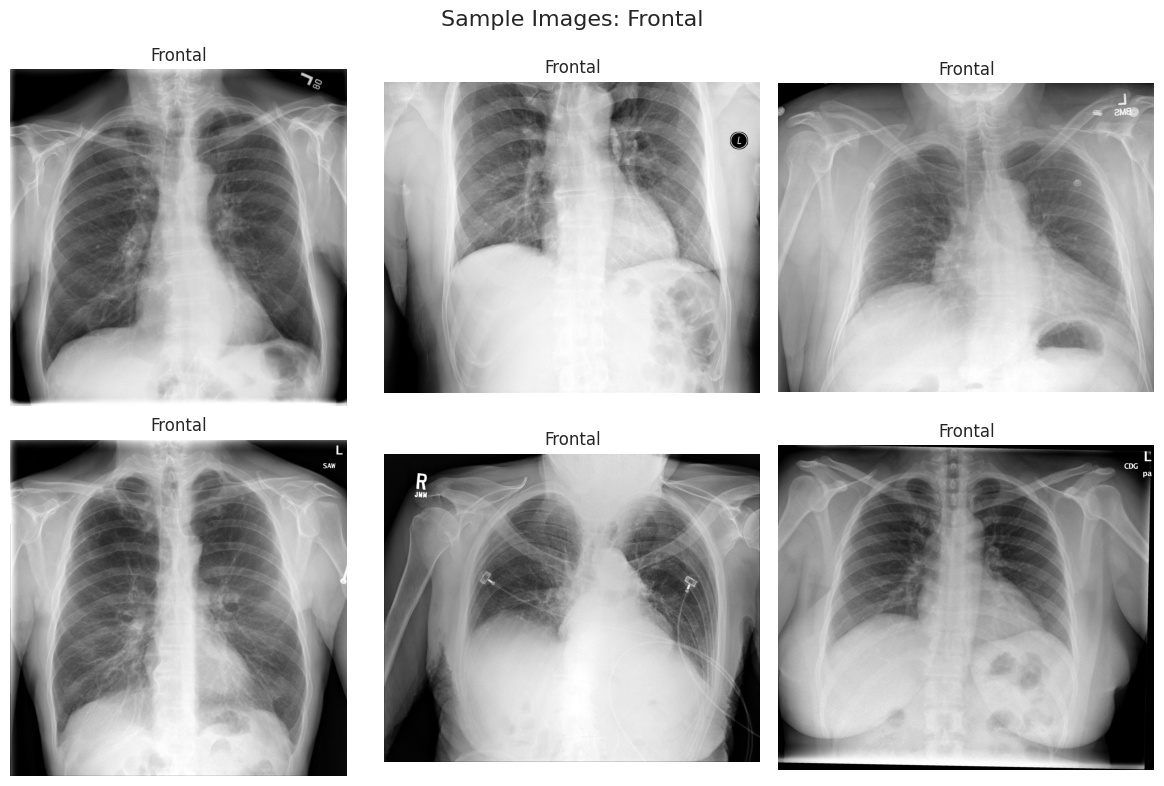

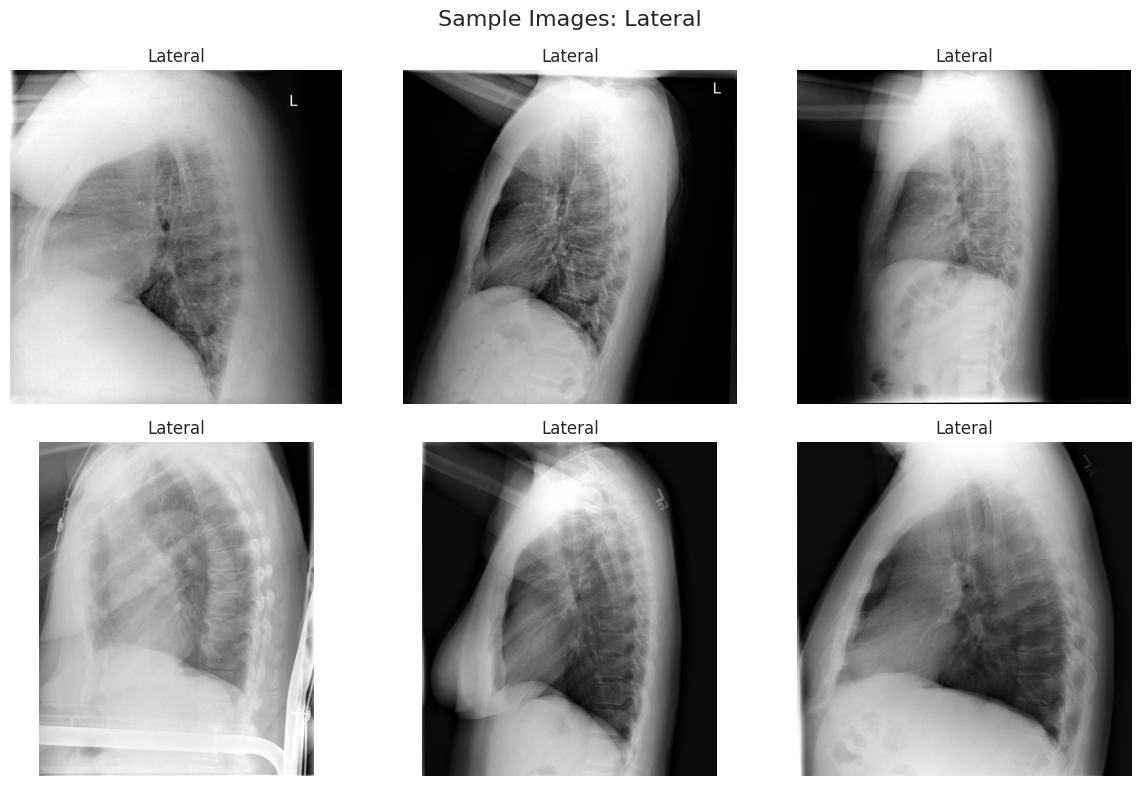

In [5]:
# Cell 5: Sample Image Grid per Projection

def plot_samples_by_projection(proj, n=6, seed=42):
    subset = meta[meta.projection == proj]
    paths  = subset.sample(n, random_state=seed)['filepath'].tolist()
    
    cols  = 3
    rows  = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))
    axes = axes.flatten()
    
    for ax, p in zip(axes, paths):
        img = Image.open(p)
        ax.imshow(img, cmap="gray")
        ax.set_title(proj)
        ax.axis("off")
    # hide any extra axes
    for ax in axes[len(paths):]:
        ax.axis("off")
        
    plt.suptitle(f"Sample Images: {proj}", fontsize=16)
    plt.tight_layout()
    plt.show()

for proj in meta['projection'].unique():
    plot_samples_by_projection(proj, n=6)

In [6]:
# Cell 6: Image Size Distribution (Height, Width)

# PIL .size returns (width, height), so reverse
dims = meta['filepath'].apply(lambda p: Image.open(p).size[::-1])
dims_df = pd.DataFrame(dims.tolist(), columns=['height','width'])

# Summary statistics
dims_df.describe()

,height,width
count,7466.000000,7466.000000
mean,2220.219395,2155.824270
std,219.141460,188.672166
min,1760.000000,1529.000000
25%,2048.000000,2048.000000
50%,2048.000000,2048.000000
75%,2496.000000,2164.000000
max,3001.000000,2891.000000


---

# Preprocessing

In [7]:
# Cell 0: Verify GPU & NVIDIA‑SMI
!nvidia-smi
import torch
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Mon Jul 14 08:13:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
# Cell 1: Suppress Warnings & Imports
import os, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

# Allow cuDNN to autotune for best performance
torch.backends.cudnn.benchmark = True

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [9]:
# Cell 2: Load Projection Metadata
projections_csv = '/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv'
proj_df = pd.read_csv(projections_csv)
print("Projections:", proj_df.shape)
proj_df.head()

Projections: (7466, 3)


,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [10]:
# Cell 3: Prepare Labels DataFrame
df = proj_df[['filename', 'projection']].dropna().reset_index(drop=True)
le = LabelEncoder()
df['label'] = le.fit_transform(df['projection'])
print("Classes:", list(le.classes_))
df.head()

Classes: ['Frontal', 'Lateral']


,filename,projection,label
0,1_IM-0001-4001.dcm.png,Frontal,0
1,1_IM-0001-3001.dcm.png,Lateral,1
2,2_IM-0652-1001.dcm.png,Frontal,0
3,2_IM-0652-2001.dcm.png,Lateral,1
4,3_IM-1384-1001.dcm.png,Frontal,0


In [11]:
# Cell 4: Build Filepaths & Verify Existence
img_dir = '/kaggle/input/chest-xrays-indiana-university/images/images_normalized'
df['filepath'] = df['filename'].map(lambda f: os.path.join(img_dir, f))
missing = df['filepath'].apply(os.path.exists).value_counts().to_dict()
print("File existence:", missing)
assert missing.get(False,0)==0, "Missing image files!"

File existence: {True: 7466}


In [12]:
# Cell 5: Train/Val Split & Transforms
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print(f"Train: {len(train_df)} samples, Val: {len(val_df)} samples")

IMG_SIZE = 224
train_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomRotation(15),
    T.RandomResizedCrop(IMG_SIZE, scale=(0.9,1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])
val_transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

Train: 5972 samples, Val: 1494 samples


In [13]:
# Cell 6: Dataset & DataLoader with pin_memory + GPU test batch
class ChestXrayDataset(Dataset):
    def __init__(self, df, transforms):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img = Image.open(row['filepath']).convert('RGB')
        img = self.transforms(img)
        label = torch.tensor(row['label'], dtype=torch.float32)
        return img, label

train_ds = ChestXrayDataset(train_df, train_transforms)
val_ds   = ChestXrayDataset(val_df,   val_transforms)

BATCH_SIZE = 32
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=4, pin_memory=True)

# Quick GPU transfer test
imgs, labels = next(iter(train_loader))
print("Before .to(device):", imgs.device, labels.device)
imgs, labels = imgs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
print("After  .to(device):", imgs.device, labels.device)
assert imgs.device.type=='cuda', "Images are not on GPU!"
assert labels.device.type=='cuda', "Labels are not on GPU!"

Before .to(device): cpu cpu
After  .to(device): cuda:0 cuda:0


# Functions

In [ ]:
import torch

def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=5):
    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(1, epochs+1):
        model.train()
        running_loss = correct = total = 0
        for imgs, labels in train_loader:
            imgs = imgs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += imgs.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        model.eval()
        vloss = vcorrect = vtotal = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True).unsqueeze(1)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                vloss += loss.item() * imgs.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                vcorrect += (preds == labels).sum().item()
                vtotal += imgs.size(0)

        val_loss = vloss / vtotal
        val_acc = vcorrect / vtotal

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pt')

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch}/{epochs} | "
              f"Train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
              f"Val:   loss={val_loss:.4f}, acc={val_acc:.4f}")

    return train_losses, train_accs, val_losses, val_accs


# Classification - Simple CNN

In [ ]:
# Cell 7: Define Simple CNN and confirm on GPU
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,32,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(), nn.MaxPool2d(2),
        )
        feat_dim = 128 * (IMG_SIZE//8) * (IMG_SIZE//8)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feat_dim,128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128,1)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

model = SimpleCNN().to(device)
print("Model parameters on:", next(model.parameters()).device)

In [ ]:
# Cell 8: Loss & Optimizer on GPU
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_losses, train_accs, val_losses, val_accs = train_model(
    model, criterion, optimizer, train_loader, val_loader, device, epochs=5
)

In [ ]:
# Cell 10: Load Best Model & Final Evaluation
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
vcorrect = vtotal = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).unsqueeze(1)
        preds = (torch.sigmoid(model(imgs)) > 0.5).float()
        vcorrect += (preds == labels).sum().item()
        vtotal   += imgs.size(0)

print(f"Final Val Accuracy: {vcorrect/vtotal:.4f}")

In [ ]:
# Cell 11: Plot Training Curves
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs,   label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()

---

# Classification—Using Pretrained Model

In [ ]:
import torchvision.models as models
import torch.nn as nn

# Load pretrained ResNet18 model from torchvision
resnet = models.resnet18(pretrained=True)

# Freeze all layers (optional) to train only the final classifier layers
for param in resnet.parameters():
    param.requires_grad = False

# Replace the final fully connected layer for binary classification
num_features = resnet.fc.in_features
resnet.fc = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 1)  # Single output neuron for binary classification
)

# Move model to the device (GPU or CPU)
model = resnet.to(device)
print("Model parameters on:", next(model.parameters()).device)


In [ ]:
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_losses, train_accs, val_losses, val_accs = train_model(
    model, criterion, optimizer, train_loader, val_loader, device, epochs=5
)

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
vcorrect = vtotal = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).unsqueeze(1)
        preds = (torch.sigmoid(model(imgs)) > 0.5).float()
        vcorrect += (preds == labels).sum().item()
        vtotal   += imgs.size(0)

print(f"Final Val Accuracy: {vcorrect/vtotal:.4f}")

In [ ]:
# Cell 11: Plot Training Curves
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs,   label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()

# Image Captioing/Report Generation with CNN + LSTM

1. Text Preprocessing: First, we need to process the report text ("findings" and "impression"). This involves cleaning the text, building a vocabulary, and creating a way to convert text to numbers that our model can understand.

In [14]:
# Cell 12: Text Preprocessing & Vocabulary Building
import nltk
from collections import Counter

# Download required tokenizer models
nltk.download('punkt')
nltk.download('punkt_tab')

# Combine findings and impression for the caption
# Fill NaN values with the word "none"
reports['caption'] = reports['findings'].fillna('none') + ' ' + reports['impression'].fillna('none')

class Vocabulary:
    """Builds a vocabulary from a list of sentences."""
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<START>", 2: "<END>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<START>": 1, "<END>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer(text):
        # Simple tokenizer: lowercase, tokenize, remove punctuation
        text = text.lower()
        tokens = nltk.tokenize.word_tokenize(text)
        return [word for word in tokens if word.isalpha()]

    def build_vocabulary(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer(sentence):
                frequencies[word] += 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

# Build the vocabulary from the report captions
vocab = Vocabulary(freq_threshold=5)
vocab.build_vocabulary(reports['caption'].tolist())
print(f"Vocabulary Size: {len(vocab)}")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Vocabulary Size: 900


2. Update the Dataset and DataLoader: Now, we'll modify the Dataset class to handle the image-caption pairs. We also need a collate_fn to pad the captions in each batch to be the same length, which is crucial for training RNNs.

In [15]:
# Cell 13: Update Dataset and Create DataLoader
from torch.nn.utils.rnn import pad_sequence

# Merge reports metadata with projections
full_df = proj_df.merge(reports, on='uid')
full_df['filepath'] = full_df['filename'].apply(lambda f: os.path.join(IMAGE_DIR, f))
full_df = full_df[full_df['filepath'].map(os.path.exists)].reset_index(drop=True)

# Split the data
train_df, val_df = train_test_split(full_df, test_size=0.2, random_state=42)

class ChestXrayCaptionDataset(Dataset):
    def __init__(self, df, vocab, transforms):
        self.df = df.reset_index(drop=True)
        self.vocab = vocab
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img = Image.open(row['filepath']).convert("RGB")
        img = self.transforms(img)

        caption = row['caption']
        numericalized_caption = [self.vocab.stoi["<START>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<END>"])

        return img, torch.tensor(numericalized_caption)

class Collate:
    """Pads captions to the same length in a batch."""
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_idx)
        return imgs, targets

# Use the same image transforms from our classification task
IMG_SIZE = 224
transforms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # 3 channels for RGB
])

# Create datasets
train_dataset = ChestXrayCaptionDataset(train_df, vocab, transforms)
val_dataset = ChestXrayCaptionDataset(val_df, vocab, transforms)

# Create data loaders
BATCH_SIZE = 32
pad_idx = vocab.stoi["<PAD>"]
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=Collate(pad_idx=pad_idx),
    pin_memory=True
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=Collate(pad_idx=pad_idx),
    pin_memory=True
)

3. Build the CNN-LSTM Model: Here we define the encoder (CNN) and decoder (LSTM). We'll use a pre-trained ResNet-152 for its powerful feature extraction capabilities.

In [16]:
# Cell 14: Define the CNN-LSTM Model
import torchvision.models as models

class CNNEncoder(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        # Use a more same ResNet
        #resnet = models.resnet18(pretrained=True)
        # Use a more powerful ResNet
        resnet = models.resnet152(pretrained=True)
        # Freeze all layers
        for param in resnet.parameters():
            param.requires_grad_(False)

        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return self.bn(features)

class LSTMDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        # Concatenate image features and caption embeddings
        embeddings = torch.cat((features.unsqueeze(1), embeddings), dim=1)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs

class CNN_LSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()
        self.encoder = CNNEncoder(embed_size)
        self.decoder = LSTMDecoder(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        """Generates a caption for a single image."""
        result_caption = []
        with torch.no_grad():
            x = self.encoder(image).unsqueeze(1)
            states = None
            for _ in range(max_length):
                hiddens, states = self.decoder.lstm(x, states)
                output = self.decoder.linear(hiddens.squeeze(1))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())

                # Prepare the next input
                x = self.decoder.embed(predicted).unsqueeze(1)

                if vocabulary.itos[predicted.item()] == "<END>":
                    break
        return [vocabulary.itos[idx] for idx in result_caption]

4. Training the Report Generation Model: Finally, we'll set up the hyperparameters, instantiate the model, and write the training loop. This loop is more complex than the one for classification because we're predicting a sequence of words.

In [17]:
# Cell 15: Set Hyperparameters and Train the Model
# Hyperparameters
embed_size = 512
hidden_size = 512
num_layers = 1
learning_rate = 3e-4
num_epochs = 50

# Instantiate the model
model = CNN_LSTM(embed_size, hidden_size, len(vocab), num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0

    for i, (imgs, captions) in enumerate(train_loader):
        imgs = imgs.to(device)
        captions = captions.to(device)

        # We don't feed the <END> token to the decoder
        captions_input = captions[:, :-1]

        # We try to predict the caption starting from the first word
        captions_target = captions[:, 1:]

        # Forward pass
        outputs = model(imgs, captions_input)

        # Reshape for CrossEntropyLoss
        # Trim the model's output to match the target's sequence length
        loss = criterion(outputs[:, :captions_target.shape[1], :].reshape(-1, outputs.shape[2]), captions_target.reshape(-1))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch} Average Loss: {avg_loss:.4f}")

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 208MB/s] 


Epoch [1/50], Step [100/187], Loss: 3.7029
Epoch 1 Average Loss: 4.5246
Epoch [2/50], Step [100/187], Loss: 3.7703
Epoch 2 Average Loss: 3.5637
Epoch [3/50], Step [100/187], Loss: 3.5988
Epoch 3 Average Loss: 3.2508
Epoch [4/50], Step [100/187], Loss: 2.9976
Epoch 4 Average Loss: 3.0469
Epoch [5/50], Step [100/187], Loss: 2.8962
Epoch 5 Average Loss: 2.8903
Epoch [6/50], Step [100/187], Loss: 2.7272
Epoch 6 Average Loss: 2.7640
Epoch [7/50], Step [100/187], Loss: 2.3835
Epoch 7 Average Loss: 2.6474
Epoch [8/50], Step [100/187], Loss: 2.5186
Epoch 8 Average Loss: 2.5566
Epoch [9/50], Step [100/187], Loss: 2.7303
Epoch 9 Average Loss: 2.4696
Epoch [10/50], Step [100/187], Loss: 2.1499
Epoch 10 Average Loss: 2.3898
Epoch [11/50], Step [100/187], Loss: 2.2362
Epoch 11 Average Loss: 2.3203
Epoch [12/50], Step [100/187], Loss: 1.9604
Epoch 12 Average Loss: 2.2524
Epoch [13/50], Step [100/187], Loss: 2.5194
Epoch 13 Average Loss: 2.1893
Epoch [14/50], Step [100/187], Loss: 1.9764
Epoch 14 Ave

KeyboardInterrupt: 

5. Inference: Generating a Report: After training, we'll want to see how well our model performs. Here's a function to take a random image from the validation set, display it, and show the generated report alongside the original one.

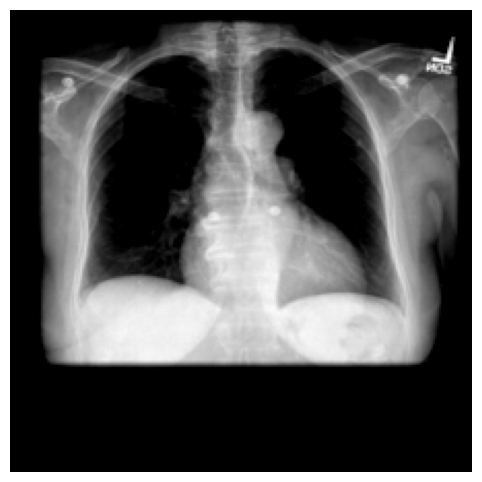

----- Original Report -----
the lungs are clear and without focal air space opacity the cardiomediastinal silhouette is at the upper limits of normal in size but stable from prior exam there is tortuosity of the thoracic aorta stable there is no pneumothorax or large pleural effusion no acute cardiopulmonary abnormality

----- Generated Report -----
the are the is there a granuloma the of aorta is the is there a pleural or density the of mediastinum within left lobe is there no effusion pneumothorax focal opacity the lung are with <UNK> there a of thoracic there a granuloma in right lobe xxxx is there


In [19]:
# Cell 16: Inference and Report Generation
import random

def generate_and_display_report(dataset, model, vocab, device, idx=None):
    """Selects an image, generates a report, and displays results."""
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)

    model.eval()

    # Get image and original caption
    img, caption_tensor = dataset[idx]
    original_caption = " ".join([vocab.itos[i.item()] for i in caption_tensor if i not in [0,1,2]])

    # Move image to device and generate report
    img_tensor = img.unsqueeze(0).to(device)
    generated_caption_tokens = model.caption_image(img_tensor, vocab)
    generated_caption = " ".join(generated_caption_tokens[:-1]) # Exclude <END>

    # Display
    plt.imshow(img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

    print("----- Original Report -----")
    print(original_caption)
    print("\n----- Generated Report -----")
    print(generated_caption)

# Generate a report for a random image in the validation set
generate_and_display_report(val_dataset, model, vocab, device)